# TinyMind汉字书法识别挑战

### 1 题目介绍

竞赛数据提供100个汉字书法单字，包括碑帖，手写书法，古汉字等。图片全部为单通道宽度jpg，宽高不定。

### 2 数据集介绍

 - 训练集：每个汉字400张图片，共计40000张图片，训练集是标注好的数据，图片按照图片上的文字分类到不同的文件夹中，也就是生活文件夹的名字就是文件夹里面所有图片的标签。
 
 
 - 测试集：
  - 第一部分：每汉字100张图片共计10000张图片，供参赛人员测试算法模型
  - 第二部分：每汉子50张以上图片共1643张图片，用来评测。

- 提交csv文件
  - 文件第一列是测试集中图片文件的文件名，第二列是推断出来的图片上文字可能的五个汉字。

### 3 思路

 - 提取数据集
 - 定义fine-tune模型
 - VGG16模型
 - ResNet50模型
 - Xception模型
 - InceptionV3模型

### 4 具体流程

**(1)提取数据集**

In [0]:
# 导入所需的模块
import os
import cv2
import numpy as np


from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


In [0]:
# 获取标签的编码器
train_path = "/content/train"
label_char = os.listdir(train_path)
label_char.sort()
encode_label = LabelBinarizer()
encode_label.fit(label_char)


LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [0]:
# 定义读取图片函数
def get_img(file_path,img_rows,img_cols):
  
    image = cv2.imread(file_path,0)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image,(img_rows,img_cols))
    feature = np.array(image,dtype=np.uint8)

    return feature

In [0]:
# 定义加载训练集的函数

def load_train_data(train_path,img_rows,img_cols):
    x_train = []
    y_train = []

    dirs = os.listdir(train_path)
    for dir_name in dirs:
    path = train_path + "/" + dir_name
    for img_name in os.listdir(path):
        feature = get_img(os.path.join(path,img_name),img_rows,img_cols)
        label = dir_name

        x_train.append(feature)
        y_train.append(label)

    # 对y_train进行one-hot编码
    y_train = np.array(encode_label.transform(y_train),dtype=np.uint8)
    # 对x_train进行转换
    x_train = np.array(x_train, dtype=np.uint8)

    # 对训练集进行随机打乱，并划分训练集和验证集
    x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.2,random_state=2019)

    return x_train,x_valid,y_train,y_valid

In [0]:
# 定义加载测试集的函数
def load_test_data(test_path,img_rows,img_cols):
    x_test_id = []
    x_test = []

    img_names = os.listdir(test_path)
    for img_name in img_names:
        feature = get_img(os.path.join(test_path,img_name),img_rows,img_cols)
        id = img_name

        x_test_id.append(id)
        x_test.append(feature)

    #对x_test进行转换
    x_test = np.array(x_test,dtype=np.uint8)

    return x_test,x_test_id

In [0]:
# 加载训练和验证数据和标签
img_rows,img_cols = 224,224
x_train,x_valid,y_train,y_valid = load_train_data(train_path,img_rows,img_cols)

In [0]:
# 加载待预测的数据和标签
test_path = "/content/test2"
x_test,x_test_id = load_test_data(test_path,img_rows,img_cols)

In [0]:
# 查看一下数据和标签
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(x_test_id[:5])

(32000, 224, 224, 3)
(32000, 100)
(8000, 224, 224, 3)
(8000, 100)
(16343, 224, 224, 3)
['e3e25bf5cb2cdef2f538ec5e2b3039f6aae6c0ef.jpg', 'cb68929c872feddcdd7d2f1d27c151e99575785f.jpg', 'dbf840d7ed6d3d3604689e1062c57f22937c20ee.jpg', 'e32473a16786a031b230ccb4ab0bc9c04a2834af.jpg', 'db8aeee15d73b601f04f008a8354bb86f3956bf9.jpg']


去


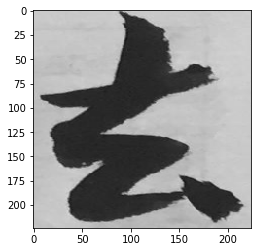

In [0]:
# 查看一下数据和标签
import matplotlib.pyplot as plt
%matplotlib inline

print(label_char[y_train[0].argmax()])

plt.imshow(x_train[0])

**（2）fine-tune模型**

  选择keras中预训练好的模型，进行fine-tune

In [0]:
# 导入开发需要的库
from keras import optimizers, Input
from keras.applications import  imagenet_utils

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.applications import *

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *

Using TensorFlow backend.


In [0]:
# 绘制训练过程中的 loss 和 acc 变化曲线
import matplotlib.pyplot as plt
%matplotlib inline

def history_plot(history_fit):
    plt.figure(figsize=(12,6))
    
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history_fit.history["acc"])
    plt.plot(history_fit.history["val_acc"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper left")
    
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history_fit.history["loss"])
    plt.plot(history_fit.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    
    plt.show()

In [0]:
# fine-tune 模型
def fine_tune_model(model, optimizer, batch_size, epochs, freeze_num):
    '''
    discription: 对指定预训练模型进行fine-tune，并保存为.hdf5格式
    
    MODEL：传入的模型，VGG16， ResNet50, ...

    optimizer: fine-tune all layers 的优化器, first part默认用adadelta
    batch_size: 每一批的尺寸，建议32/64/128
    epochs: fine-tune all layers的代数
    freeze_num: first part冻结卷积层的数量
    '''

    # first: 仅训练全连接层（权重随机初始化的）
    # 冻结所有卷积层
    
    for layer in model.layers[:freeze_num]:
        layer.trainable = False
    
    model.compile(optimizer='adadelta', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x=x_train, 
              y=y_train, 
              batch_size=batch_size, 
              epochs=2, 
              shuffle=True, 
              verbose=1, 
              validation_data=(x_valid, y_valid))
    
    print('Finish step_1')
    
    # second: fine-tune all layers
    for layer in model.layers[:]:
        layer.trainable = True
    
    rc = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=2,
                               verbose=1,
                               min_delta=1e-4,
                               mode='min')

    model_name = model.name  + '.hdf5'
    mc = ModelCheckpoint(model_name, 
                         monitor='val_loss', 
                         save_best_only=True,
                         mode='min')
    
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history_fit = model.fit(x=x_train, 
                            y=y_train, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            shuffle=True, 
                            verbose=1, 
                            validation_data=(x_valid, y_valid),
                            callbacks=[mc, rc])
    print('Finish fine-tune')
    
    #展示fine-tune过程中的loss和accuracy变化曲线
    history_plot(history_fit)

**（3）VGG16**

`a.定义VGG16模型`

In [0]:
# 定义一个VGG16的模型
def vgg16_model(img_rows, img_cols):
    x = Input(shape=(img_rows, img_cols, 3))
    x = Lambda(imagenet_utils.preprocess_input)(x)
    
    base_model = VGG16(input_tensor=x, weights='imagenet', 
                      include_top=False, pooling='avg')
    x = base_model.output
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(100, activation='softmax', name='predictions')(x)
    
    vgg_model = Model(inputs=base_model.input, outputs=predictions, name='vgg16')
    
    return vgg_model

In [0]:
# 创建VGG16模型
img_rows, img_cols = 224, 224
vgg_model = vgg16_model(img_rows,img_cols)

W0822 00:50:46.733558 140527144740736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 00:50:46.777397 140527144740736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 00:50:46.795861 140527144740736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 00:50:46.843127 140527144740736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 2s 0us/step


W0822 00:50:50.164506 140527144740736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0822 00:50:50.165810 140527144740736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0822 00:50:53.323976 140527144740736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# 列出每一层的序号和名字
for i,layer in enumerate(vgg_model.layers):
    print(i,layer.name)

0 input_1
1 lambda_1
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool
20 global_average_pooling2d_1
21 fc1
22 dropout_1
23 predictions


`b.VGG16模型训练`

W0822 00:51:06.912699 140527144740736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0822 00:51:07.054586 140527144740736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 369s 12ms/step - loss: 4.0044 - acc: 0.1178 - val_loss: 3.0097 - val_acc: 0.2735
Epoch 2/2
32000/32000 [==============================] - 363s 11ms/step - loss: 3.0632 - acc: 0.2520 - val_loss: 2.5701 - val_acc: 0.3688
Finish step_1
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 935s 29ms/step - loss: 1.9517 - acc: 0.4939 - val_loss: 1.0027 - val_acc: 0.7420
Epoch 2/10
32000/32000 [==============================] - 930s 29ms/step - loss: 1.0751 - acc: 0.7098 - val_loss: 0.6523 - val_acc: 0.8354
Epoch 3/10
32000/32000 [==============================] - 930s 29ms/step - loss: 0.7296 - acc: 0.8001 - val_loss: 0.5144 - val_acc: 0.8735
Epoch 4/10
32000/32000 [==============================] - 931s 29ms/step - loss: 0.5302 - acc: 0.8520 - val_loss: 0.5459 - val_acc: 0.8614
Epoch 5/10
32000/32000 [==============================] 

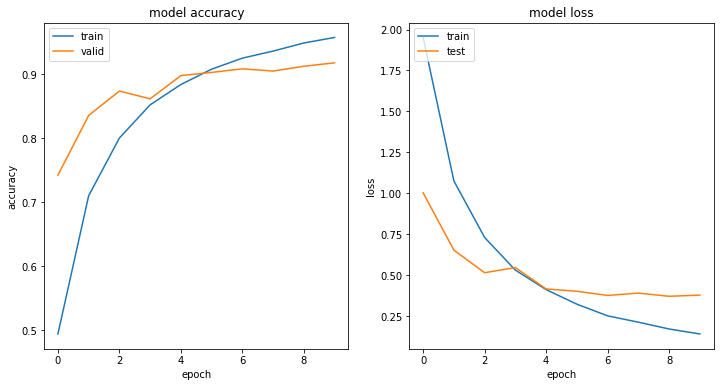

In [0]:
# 模型训练
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


batch_size = 32
epochs = 10
freeze_num = 19
    
fine_tune_model(vgg_model, optimizer, batch_size, epochs, freeze_num)

`c.VGG16模型预测`

In [0]:
# 加载模型权重
vgg_model.load_weights("vgg16.hdf5")

In [0]:
# 获取预测结果
y_preds = vgg_model.predict(x_test)

16343
(1, 100)
[' 足良思皇定']


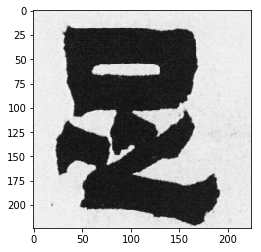

In [0]:
# 测试预测的结果
print(x_test.shape[0])
plt.imshow(x_test[2])

test_img = np.expand_dims(x_test[2],axis=0)
y_pred = vgg_model.predict(test_img)
print(y_pred.shape)

labels=[]
pred_dict = {key:value for key,value in enumerate(y_pred[0])} 
pred_sorted = sorted(pred_dict.items(), key=lambda item:(-item[1])) 
top_5 = " "
for j in range(5):
    index = pred_sorted[j][0]
    top_5 += label_char[index]
        
labels.append(top_5) 

print(labels)

In [0]:
from pandas import DataFrame

# 定义创建csv文件的函数
def create_submission(y_preds,x_test_id):
    labels = []
    for i,_ in enumerate(x_test_id):  

        # key代表预测的character的序号，value代表预测概率
        pred_dict = {key:value for key,value in enumerate(y_preds[i])} 
        pred_sorted = sorted(pred_dict.items(), key=lambda item:(-item[1])) 
        # pred_sorted: [(k1,v1), (k2,v2), ...]
        top_5 = ''
        for j in range(5):
            index = pred_sorted[j][0]
            top_5 += label_char[index]

        labels.append(top_5) 

    result = DataFrame(labels,columns=["labels"])
    result.insert(0,"filename",x_test_id)

    result.to_csv("submit.csv",index=None)

    print("create submission succesfuly")

In [0]:
# 生成csv文件
create_submission(y_preds,x_test_id)

create submission succesfuly


In [0]:
import pandas as pd
# 预览一下提交文件
predict_df = pd.read_csv("submit.csv")
predict_df.head()

,filename,labels
0,e3e25bf5cb2cdef2f538ec5e2b3039f6aae6c0ef.jpg,黄春寒莫虎
1,cb68929c872feddcdd7d2f1d27c151e99575785f.jpg,好秋林物游
2,dbf840d7ed6d3d3604689e1062c57f22937c20ee.jpg,足良思皇定
3,e32473a16786a031b230ccb4ab0bc9c04a2834af.jpg,多名易臣印
4,db8aeee15d73b601f04f008a8354bb86f3956bf9.jpg,物易申虎家


**（4）ResNet**

`a.ResNet50模型定义`

In [0]:
# 定义一个ResNet50的模型
def restnet50_model(img_rows, img_cols):
    x = Input(shape=(img_rows, img_cols, 3))
    x = Lambda(imagenet_utils.preprocess_input)(x)
    
    base_model = ResNet50(input_tensor=x, weights='imagenet', 
                      include_top=False, pooling='avg')
    x = base_model.output
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(100, activation='softmax', name='predictions')(x)
    
    resnet_model = Model(inputs=base_model.input, outputs=predictions, name='resnet50')
    
    return resnet_model

In [44]:
# 创建ResNet50模型

img_rows, img_cols = 224, 224
resnet_model = restnet50_model(img_rows,img_cols)

94658560/94653016 [==============================] - 8s 0us/step


In [0]:
# 列出每一层的序号和名字
for i,layer in enumerate(resnet_model.layers):
    print(i,layer.name)

0 input_1
1 lambda_1
2 conv1_pad
3 conv1
4 bn_conv1
5 activation_1
6 pool1_pad
7 max_pooling2d_1
8 res2a_branch2a
9 bn2a_branch2a
10 activation_2
11 res2a_branch2b
12 bn2a_branch2b
13 activation_3
14 res2a_branch2c
15 res2a_branch1
16 bn2a_branch2c
17 bn2a_branch1
18 add_1
19 activation_4
20 res2b_branch2a
21 bn2b_branch2a
22 activation_5
23 res2b_branch2b
24 bn2b_branch2b
25 activation_6
26 res2b_branch2c
27 bn2b_branch2c
28 add_2
29 activation_7
30 res2c_branch2a
31 bn2c_branch2a
32 activation_8
33 res2c_branch2b
34 bn2c_branch2b
35 activation_9
36 res2c_branch2c
37 bn2c_branch2c
38 add_3
39 activation_10
40 res3a_branch2a
41 bn3a_branch2a
42 activation_11
43 res3a_branch2b
44 bn3a_branch2b
45 activation_12
46 res3a_branch2c
47 res3a_branch1
48 bn3a_branch2c
49 bn3a_branch1
50 add_4
51 activation_13
52 res3b_branch2a
53 bn3b_branch2a
54 activation_14
55 res3b_branch2b
56 bn3b_branch2b
57 activation_15
58 res3b_branch2c
59 bn3b_branch2c
60 add_5
61 activation_16
62 res3c_branch2a
63 b

`b.ResNet50模型训练`

Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 167s 5ms/step - loss: 2.7670 - acc: 0.3084 - val_loss: 2.8538 - val_acc: 0.3187
Epoch 2/2
32000/32000 [==============================] - 163s 5ms/step - loss: 2.4390 - acc: 0.3798 - val_loss: 2.8721 - val_acc: 0.3387
Finish step_1
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 461s 14ms/step - loss: 1.8796 - acc: 0.5350 - val_loss: 1.0564 - val_acc: 0.7298
Epoch 2/10
32000/32000 [==============================] - 450s 14ms/step - loss: 0.7572 - acc: 0.8001 - val_loss: 0.8284 - val_acc: 0.7805
Epoch 3/10
32000/32000 [==============================] - 449s 14ms/step - loss: 0.5099 - acc: 0.8641 - val_loss: 0.6372 - val_acc: 0.8349
Epoch 4/10
32000/32000 [==============================] - 449s 14ms/step - loss: 0.3501 - acc: 0.9027 - val_loss: 0.4703 - val_acc: 0.8792
Epoch 5/10
32000/32000 [==============================] - 

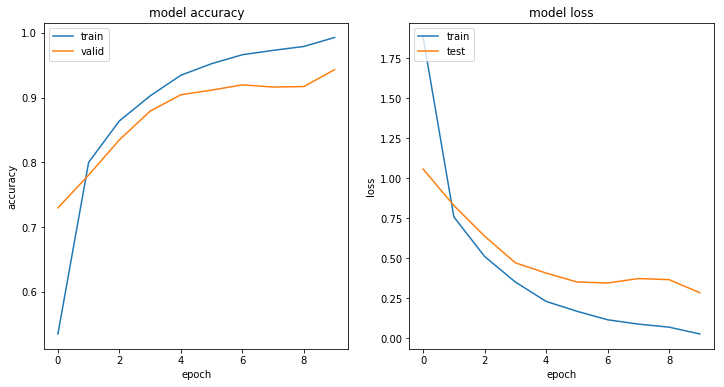

In [0]:
# 模型训练

optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


batch_size = 32
epochs = 10
freeze_num = 175
    
fine_tune_model(resnet_model, optimizer, batch_size, epochs, freeze_num)

`c.ResNet模型预测`

In [0]:
# 加载模型权重
resnet_model.load_weights("resnet50.hdf5")

In [0]:
# 获取预测结果
y_preds = resnet_model.predict(x_test)

In [0]:
from pandas import DataFrame

# 定义创建csv文件的函数
def create_submission(y_preds,x_test_id):
    labels = []
    for i,_ in enumerate(x_test_id):  

        # key代表预测的character的序号，value代表预测概率
        pred_dict = {key:value for key,value in enumerate(y_preds[i])} 
        pred_sorted = sorted(pred_dict.items(), key=lambda item:(-item[1])) 
        # pred_sorted: [(k1,v1), (k2,v2), ...]
        top_5 = ''
        for j in range(5):
            index = pred_sorted[j][0]
            top_5 += label_char[index]

        labels.append(top_5) 

    result = DataFrame(labels,columns=["labels"])
    result.insert(0,"filename",x_test_id)

    result.to_csv("submit2.csv",index=None)

    print("create submission succesfuly")

In [0]:
# 生成csv文件
create_submission(y_preds,x_test_id)

create submission succesfuly


In [0]:
import pandas as pd
# 预览一下提交文件
predict_df = pd.read_csv("submit2.csv")
predict_df.head()

,filename,labels
0,d280b395dfb55df44007304c954a9ec429c4331b.jpg,我多家衣氏
1,93b77c8918694f4fac8c9cfc14987e08940c909a.jpg,白申臣良父
2,b6b9f3cd882f419bec747a46376a5c9348ce60f3.jpg,武氏老春衣
3,e076e7d8ef6924c219c6829a79c267a5f55880c8.jpg,命令合御始
4,f75018a3c2e66fccd27b818c130e4d932d48e6f1.jpg,父必永氏我


**（5）Xception**

`a.定义Xception模型`

In [0]:
# 定义一个Xception的模型
def xception_model(img_rows, img_cols):
    x = Input(shape=(img_rows, img_cols, 3))
    x = Lambda(imagenet_utils.preprocess_input)(x)
    
    base_model = Xception(input_tensor=x, weights='imagenet', 
                      include_top=False, pooling='avg')
    x = base_model.output
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(100, activation='softmax', name='predictions')(x)
    
    xception_model = Model(inputs=base_model.input, outputs=predictions, name='xception')
    
    return xception_model

In [0]:
# 创建Xception模型

img_rows, img_cols = 224, 224
xception_model = xception_model(img_rows,img_cols)

In [0]:
# 列出每一层的序号和名字
for i,layer in enumerate(xception_model.layers):
    print(i,layer.name)

0 input_3
1 lambda_3
2 block1_conv1
3 block1_conv1_bn
4 block1_conv1_act
5 block1_conv2
6 block1_conv2_bn
7 block1_conv2_act
8 block2_sepconv1
9 block2_sepconv1_bn
10 block2_sepconv2_act
11 block2_sepconv2
12 block2_sepconv2_bn
13 conv2d_95
14 block2_pool
15 batch_normalization_95
16 add_1
17 block3_sepconv1_act
18 block3_sepconv1
19 block3_sepconv1_bn
20 block3_sepconv2_act
21 block3_sepconv2
22 block3_sepconv2_bn
23 conv2d_96
24 block3_pool
25 batch_normalization_96
26 add_2
27 block4_sepconv1_act
28 block4_sepconv1
29 block4_sepconv1_bn
30 block4_sepconv2_act
31 block4_sepconv2
32 block4_sepconv2_bn
33 conv2d_97
34 block4_pool
35 batch_normalization_97
36 add_3
37 block5_sepconv1_act
38 block5_sepconv1
39 block5_sepconv1_bn
40 block5_sepconv2_act
41 block5_sepconv2
42 block5_sepconv2_bn
43 block5_sepconv3_act
44 block5_sepconv3
45 block5_sepconv3_bn
46 add_4
47 block6_sepconv1_act
48 block6_sepconv1
49 block6_sepconv1_bn
50 block6_sepconv2_act
51 block6_sepconv2
52 block6_sepconv2_b

`b.Xception模型训练`

In [0]:
# 模型训练

optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


batch_size = 32
epochs = 15
freeze_num = 132
    
fine_tune_model(xception_model, optimizer, batch_size, epochs, freeze_num)

`c.Xception模型预测`

In [0]:
# 加载模型权重
xception_model.load_weights("xception.hdf5")

In [0]:
# 获取预测结果
y_preds = xception_model.predict(x_test)

In [0]:
from pandas import DataFrame

# 定义创建csv文件的函数
def create_submission(y_preds,x_test_id):
    labels = []
    for i,_ in enumerate(x_test_id):  

        # key代表预测的character的序号，value代表预测概率
        pred_dict = {key:value for key,value in enumerate(y_preds[i])} 
        pred_sorted = sorted(pred_dict.items(), key=lambda item:(-item[1])) 
        # pred_sorted: [(k1,v1), (k2,v2), ...]
        top_5 = ''
        for j in range(5):
            index = pred_sorted[j][0]
            top_5 += label_char[index]

        labels.append(top_5) 

    result = DataFrame(labels,columns=["labels"])
    result.insert(0,"filename",x_test_id)

    result.to_csv("submit3.csv",index=None)

    print("create submission succesfuly")

In [0]:
# 生成csv文件
create_submission(y_preds,x_test_id)

create submission succesfuly


In [0]:
import pandas as pd
# 预览一下提交文件
predict_df = pd.read_csv("submit.csv")
predict_df.head()

,filename,labels
0,d280b395dfb55df44007304c954a9ec429c4331b.jpg,我孝遂受敬
1,93b77c8918694f4fac8c9cfc14987e08940c909a.jpg,白司官臣周
2,b6b9f3cd882f419bec747a46376a5c9348ce60f3.jpg,武春氏遂虎
3,e076e7d8ef6924c219c6829a79c267a5f55880c8.jpg,命令合衣右
4,f75018a3c2e66fccd27b818c130e4d932d48e6f1.jpg,父氏足名左


**（6）IncpetionV3**

`a.InceptionV3模型定义`

In [0]:
# 定义一个Inception的模型
def inception_model(img_rows, img_cols):
    x = Input(shape=(img_rows, img_cols, 3))
    x = Lambda(imagenet_utils.preprocess_input)(x)
    
    base_model = inception_v3.InceptionV3(input_tensor=x, weights='imagenet', 
                      include_top=False, pooling='avg')
    x = base_model.output
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(100, activation='softmax', name='predictions')(x)
    
    inception_model = Model(inputs=base_model.input, outputs=predictions, name='inceptionv3')
    
    return inception_model

In [0]:
# 创建Incpetion模型

img_rows, img_cols = 224, 224
inception_model = inception_model(img_rows,img_cols)

In [0]:
# 列出每一层的序号和名字
for i,layer in enumerate(inception_model.layers):
    print(i,layer.name)

0 input_2
1 lambda_2
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed0
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 average_pooling2d_2
52 conv2d_13
53 conv2d_15
54 conv2d_18
55 conv2d_19
56 batch_normalization_13
57

`b.InceptionV3模型训练`

Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 233s 7ms/step - loss: 4.5317 - acc: 0.0246 - val_loss: 14.8521 - val_acc: 0.0125
Epoch 2/2
32000/32000 [==============================] - 228s 7ms/step - loss: 4.1858 - acc: 0.0615 - val_loss: 15.5956 - val_acc: 0.0094
Finish step_1
Train on 32000 samples, validate on 8000 samples
Epoch 1/15
32000/32000 [==============================] - 734s 23ms/step - loss: 2.4291 - acc: 0.4049 - val_loss: 1.2303 - val_acc: 0.6876
Epoch 2/15
32000/32000 [==============================] - 722s 23ms/step - loss: 0.8600 - acc: 0.7824 - val_loss: 0.6809 - val_acc: 0.8305
Epoch 3/15
32000/32000 [==============================] - 734s 23ms/step - loss: 0.5294 - acc: 0.8671 - val_loss: 0.5890 - val_acc: 0.8536
Epoch 4/15
32000/32000 [==============================] - 735s 23ms/step - loss: 0.3792 - acc: 0.9036 - val_loss: 0.4225 - val_acc: 0.8999
Epoch 5/15
32000/32000 [==============================] 

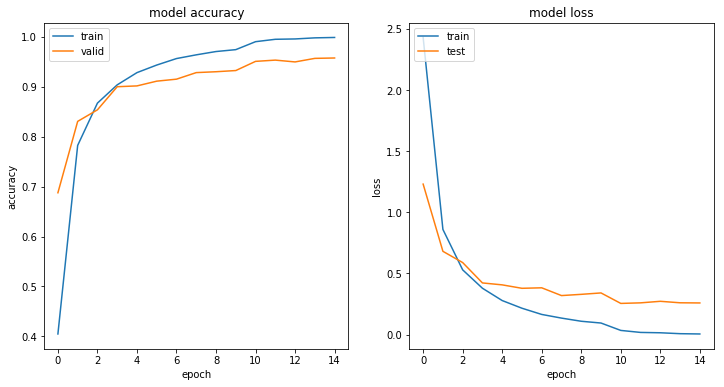

In [0]:
# 模型训练

optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


batch_size = 32
epochs = 15
freeze_num = 311
    
fine_tune_model(inception_model, optimizer, batch_size, epochs, freeze_num)

`c.InceptionV3模型预测`

In [0]:
# 加载模型权重
inception_model.load_weights("inceptionv3.hdf5")

In [0]:
# 获取预测结果
y_preds = inception_model.predict(x_test)

In [0]:
from pandas import DataFrame

# 定义创建csv文件的函数
def create_submission(y_preds,x_test_id):
    labels = []
    for i,_ in enumerate(x_test_id):  

        # key代表预测的character的序号，value代表预测概率
        pred_dict = {key:value for key,value in enumerate(y_preds[i])} 
        pred_sorted = sorted(pred_dict.items(), key=lambda item:(-item[1])) 
        # pred_sorted: [(k1,v1), (k2,v2), ...]
        top_5 = ''
        for j in range(5):
            index = pred_sorted[j][0]
            top_5 += label_char[index]

        labels.append(top_5) 

    result = DataFrame(labels,columns=["labels"])
    result.insert(0,"filename",x_test_id)

    result.to_csv("submit4.csv",index=None)

    print("create submission succesfuly")

In [38]:
# 生成csv文件
create_submission(y_preds,x_test_id)

create submission succesfuly


In [39]:
import pandas as pd
# 预览一下提交文件
predict_df = pd.read_csv("submit4.csv")
predict_df.head()

,filename,labels
0,e3e25bf5cb2cdef2f538ec5e2b3039f6aae6c0ef.jpg,通海徐建深
1,cb68929c872feddcdd7d2f1d27c151e99575785f.jpg,好世御秋始
2,dbf840d7ed6d3d3604689e1062c57f22937c20ee.jpg,足从正起良
3,e32473a16786a031b230ccb4ab0bc9c04a2834af.jpg,多名易受印
4,db8aeee15d73b601f04f008a8354bb86f3956bf9.jpg,易物我虎必
